Reading : 100%|██████████| 337/337 [00:04<00:00, 84.04it/s]


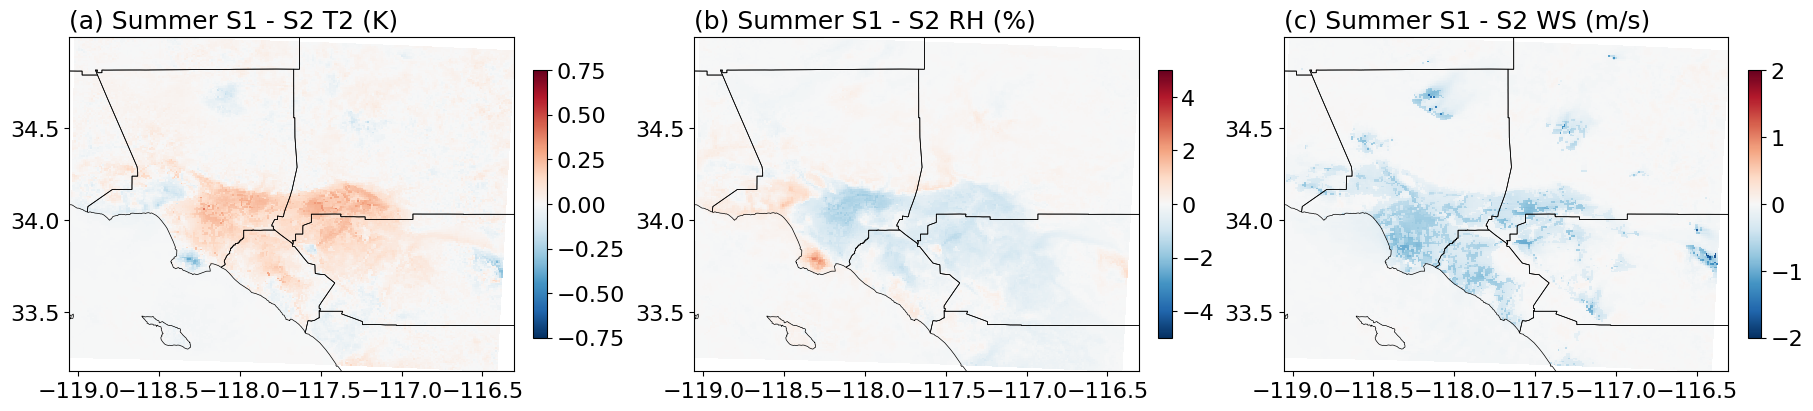

In [7]:
import os
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
from tqdm import tqdm

seasons = {
    'Summer': {
        'dirs': {
            'LCZ_LA':      "/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_UQ/test/WRF_PCE_UQ_07_LA/",
            'LCZ_Default': "/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_UQ/test/WRF_PCE_UQ_07_Default/",
            'NLCD_Default':"/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_UQ/test/WRF_PCE_UQ_07_NLCD_Default/"
        },
        'timerange': (datetime(2019,7,3,0,0,0), datetime(2019,7,17,0,0,0))
    },
    'Winter': {
        'dirs': {
            'LCZ_LA':      "/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_UQ/test/WRF_PCE_UQ_01_LA/",
            'LCZ_Default': "/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_UQ/test/WRF_PCE_UQ_01_Default/",
            'NLCD_Default':"/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_UQ/test/WRF_PCE_UQ_01_nlcd_default/"
        },
        'timerange': (datetime(2019,1,8,0,0,0), datetime(2019,1,22,0,0,0))
    }
}

manual_vlims = {'T2':(-0.75,0.75), 'RH':(-5,5), 'WS':(-2,2)}
units = {'T2':'K', 'RH':'%', 'WS':'m/s'}

shp = gpd.read_file("../Boundary/cb_2018_us_county_500k.shp").to_crs("EPSG:4326")

def list_files_in_timerange(folder, st, et):
    files = sorted(glob.glob(os.path.join(folder, "wrfout_d02*")))
    sel = []
    for f in files:
        name   = os.path.basename(f)
        ts_str = name.split('_d02_')[-1]
        try:
            ts = datetime.strptime(ts_str, "%Y-%m-%d_%H:%M:%S")
        except:
            continue
        if st <= ts <= et:
            sel.append(f)
    return sel

def compute_rh_from_q(psfc_pa, q_kgkg, t_k):
    """
    psfc_pa: Pa
    q_kgkg:  kg/kg (specific humidity)
    t_k:     K
    return:  RH (%)
    """
    es = 611.2 * np.exp(17.67 * (t_k - 273.15) / (t_k - 29.65))

    e = (q_kgkg * psfc_pa) / (0.622 + 0.378 * q_kgkg)

    rh = 100.0 * e / es
    rh = rh.clip(min=0, max=100)
    return rh

def compute_means(folder, st, et):
    files = list_files_in_timerange(folder, st, et)
    if len(files) == 0:
        raise FileNotFoundError(f"No wrfout_d02 files found in time range: {folder}")

    sum_T2 = sum_RH = sum_WS = None
    n = 0

    for fp in tqdm(files, desc=f"Reading {os.path.basename(folder)}"):
        with xr.open_dataset(fp) as ds:
            T2   = ds["T2"].mean("Time")      # (y, x)
            PSFC = ds["PSFC"].mean("Time")    # (y, x)
            Q2   = ds["Q2"].mean("Time")      # (y, x)
            U10  = ds["U10"].mean("Time")
            V10  = ds["V10"].mean("Time")

            RH = compute_rh_from_q(PSFC, Q2, T2)
            WS = np.sqrt(U10**2 + V10**2)

            if sum_T2 is None:
                sum_T2 = T2.copy(deep=True)
                sum_RH = RH.copy(deep=True)
                sum_WS = WS.copy(deep=True)
            else:
                sum_T2 += T2
                sum_RH += RH
                sum_WS += WS

            n += 1

    return sum_T2 / n, sum_RH / n, sum_WS / n

means = {}
for s, cfg in seasons.items():
    means[s] = {}
    st, et = cfg["timerange"]
    for k, folder in cfg["dirs"].items():
        means[s][k] = compute_means(folder, st, et)

diffs = {}
for s in seasons:
    T2_la, RH_la, WS_la = means[s]["LCZ_LA"]
    T2_ld, RH_ld, WS_ld = means[s]["LCZ_Default"]
    T2_nd, RH_nd, WS_nd = means[s]["NLCD_Default"]

    diffs[(s, "S1 - S2")] = dict(
        T2=(T2_la - T2_ld),
        RH=(RH_la - RH_ld),
        WS=(WS_la - WS_ld),
    )
    diffs[(s, "S2 - S3")] = dict(
        T2=(T2_ld - T2_nd),
        RH=(RH_ld - RH_nd),
        WS=(WS_ld - WS_nd),
    )

sample_files = list_files_in_timerange(
    seasons["Summer"]["dirs"]["LCZ_LA"],
    *seasons["Summer"]["timerange"]
)
if len(sample_files) == 0:
    raise FileNotFoundError("No sample wrfout found for lon/lat extraction.")

with xr.open_dataset(sample_files[0]) as ds_sample:
    lons = ds_sample["XLONG"].isel(Time=0).values
    lats = ds_sample["XLAT"].isel(Time=0).values

row_order = [
    ("Summer", "S1 - S2"),
]

# ===== 画图（修复 axes 维度问题：squeeze=False 强制 2D）=====
nrows = len(row_order)
ncols = 3
fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(18, 4 * nrows),
    constrained_layout=True,
    squeeze=False
)

letters = [f"({c})" for c in list("abcdefghijklmnopqrstuvwxyz")]

plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

for i, (season, diffkey) in enumerate(row_order):
    for j, var in enumerate(["T2", "RH", "WS"]):
        ax = axes[i, j]
        da = diffs[(season, diffkey)][var]

        im = ax.pcolormesh(
            lons, lats, da.values,
            cmap="RdBu_r",
            vmin=manual_vlims[var][0],
            vmax=manual_vlims[var][1],
            shading="auto"
        )

        shp.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)

        k = i * ncols + j
        ax.set_title(
            f"{letters[k]} {season} {diffkey} {var} ({units[var]})",
            loc="left", fontsize=18
        )

        ax.set_xlim(lons.min(), lons.max())
        ax.set_ylim(lats.min(), lats.max())

        fig.colorbar(im, ax=ax, orientation="vertical", pad=0.02, aspect=20, shrink=0.8)

plt.show()
